<a href="https://colab.research.google.com/github/Erike-Simon/Airbnb-Project/blob/main/evoRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

**Programa de Pós-Graduação em Engenharia da Computação - PPGEC UPE**

**Aluno:** *Erike Simon Costa Cativo do Nascimento*

---



#### Obteção e tratamento dos dados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

url_rec = "https://raw.githubusercontent.com/domingos108/hybrid_system_forecast/master/dataset/baseRECIFE.xlsx"
url_for = "https://raw.githubusercontent.com/domingos108/hybrid_system_forecast/master/dataset/baseFortaleza.xlsx"
url_nat = "https://raw.githubusercontent.com/domingos108/hybrid_system_forecast/master/dataset/BaseNatal.xlsx"

df_rec = pd.read_excel(url_rec)
df_for = pd.read_excel(url_for)
df_nat = pd.read_excel(url_nat)

##### Análises base Recife

In [ ]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  144 non-null    int64  
 1   Target      144 non-null    float64
 2   ARIMA       144 non-null    float64
 3   ARIMAX      144 non-null    float64
 4   SPLIT       144 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
df_rec.describe()

,Unnamed: 0,Target,ARIMA,ARIMAX
count,144.000000,144.000000,144.000000,144.000000
mean,71.500000,2.119913,2.168661,2.155282
std,41.713307,0.426137,0.331190,0.348289
min,0.000000,1.064516,1.236068,0.975823
25%,35.750000,1.797590,1.925432,1.891576
50%,71.500000,2.156224,2.142119,2.210553
75%,107.250000,2.465833,2.430487,2.429479
max,143.000000,2.872864,2.791146,2.729043


**Estacionariedade**

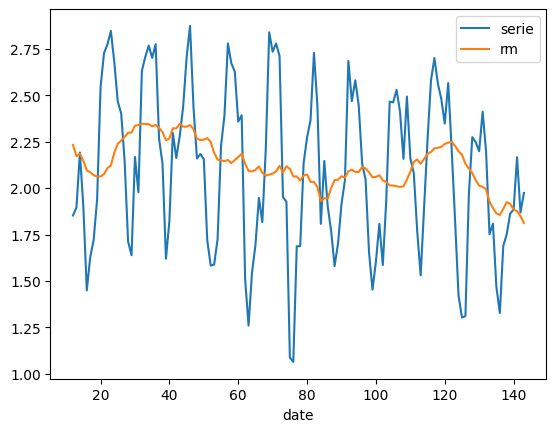

In [ ]:
# Função média móvel
def show_tend(ts, rm_size):
  df_show = pd.DataFrame()
  df_show['serie'] = ts.values[rm_size:]
  df_show['rm'] = ts.rolling(rm_size).mean().values[rm_size:]

  df_show['date'] = ts.index.to_list()[rm_size:]
  df_show.set_index('date', inplace=True)
  df_show.plot()
  plt.show()

ts_rec = df_rec['Target']
rm_size = 12
show_tend(ts_rec, rm_size)

Funções de autocorrelação (ACF) e autocorrelação parcial (PACF)

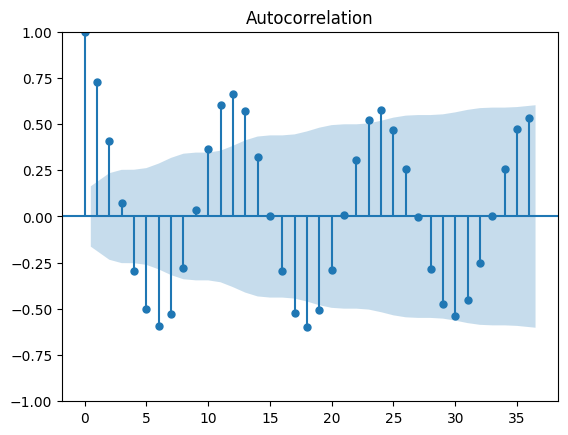

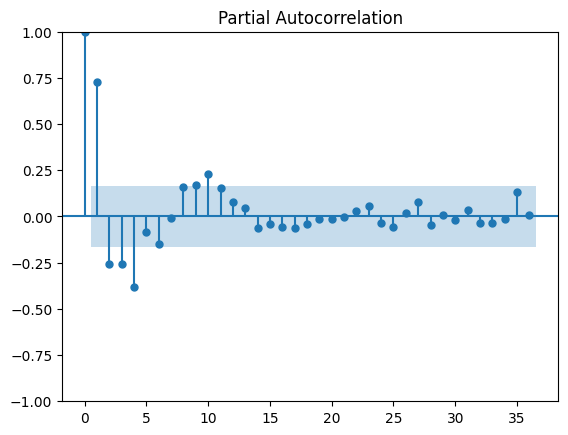

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_rec, lags=36)
plt.show()
plot_pacf(ts_rec, lags=36)
plt.show()

Teste de estacionariedade **KPSS**

In [ ]:
from statsmodels.tsa.stattools import kpss

stat_rec, p_value_rec, lags_rec, crit_rec = kpss(ts_rec, regression='c')

print("BASE RECIFE\n")
print(f"KPSS Statistic: {round(stat_rec, 2)}")
print(f"p-value: {round(p_value_rec, 2)}")
print("Nº de lags: ",round(lags_rec, 2))
print("\nValores críticos:\n")
for chave, valor in crit_rec.items():
    print("{} : {:0.2f}".format(chave, valor))

BASE RECIFE

KPSS Statistic: 0.33
p-value: 0.1
Nº de lags:  6

Valores críticos:

10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


C:\Users\Erike Simon\AppData\Local\Temp\ipykernel_1572\1963459826.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat_rec, p_value_rec, lags_rec, crit_rec = kpss(ts_rec, regression='c')


O KPSS é outro teste para verificar a estacionariedade de uma série temporal. As hipóteses nula e alternativa do teste KPSS são opostas às do teste ADF:

- H₀ (nula): o processo é estacionário em termos de tendência [se p > 0.05]

- H₁ (alternativa): a série tem raiz unitária (não é estacionária) [se p =< 0.05]

-> `KPSS Statistic = 0.33` é menor do que todos os valores críticos (1, 3 e 10%).

-> `p-value = 0.1 > 0.05` -> há evidência de que a série é estacionária, não necessitando de diferenciação.

Teste **ADF** (Dickey-Fuller)

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Teste ADF na coluna Target
resultado = adfuller(ts_rec)

print("BASE RECIFE\n")
print("ADF Statistic:", round(resultado[0], 2))
print("p-value:", round(resultado[1], 2))
print("Nº de lags:", resultado[2])
print("Nº de observações:", resultado[3])
print("Valores críticos:")
for chave, valor in resultado[4].items():
    print(f"   {chave}: {valor}")

BASE RECIFE

ADF Statistic: -1.45
p-value: 0.56
Nº de lags: 10
Nº de observações: 133
Valores críticos:
   1%: -3.480500383888377
   5%: -2.8835279559405045
   10%: -2.578495716547007


O teste **ADF** verifica se a série possui raiz unitária, isto é, se ela é não estacionária.
As hipóteses são:

- H₀ (nula): a série tem raiz unitária (ou seja, não é estacionária) [se p > 0.05]

- H₁ (alternativa): a série não tem raiz unitária (ou seja, é estacionária) [se p=< 0.05]

-> `ADF Statistic = -1.45` é mais alto (menos negativo) do que todos os valores críticos (1, 3 e 10%).

-> `p-value = 0.557 > 0.05` (não rejeitamos H₀, ou seja, **a serie é não estacionária**)

*p-values* **KPSS** e **ADF** discordam, indicando que a série é estacionária em termos de tendência. Essa tendência precisa ser removida para tornar a série estritamente estacionária.

Podemos aplicar a diferenciação e reaplicar os testes.

Plot da série após a diferenciação

<Axes: >

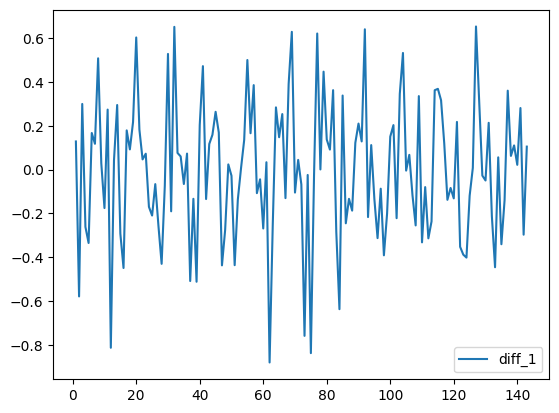

In [ ]:
df_diff_rec = pd.DataFrame()
df_diff_rec['diff_1'] = ts_rec.diff().iloc[1:]

df_diff_rec.plot()

Funções de autocorrelação (ACF) e autocorrelação parcial (PACF) (PÓS DIFERENCIAÇÃO)

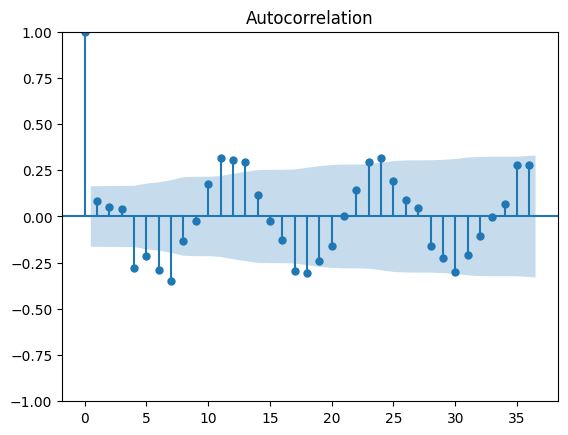

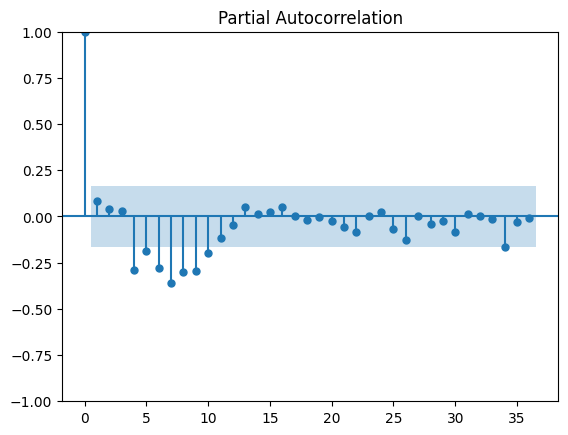

In [ ]:
ts_rec = df_diff_rec['diff_1']
plot_acf(ts_rec, lags=36)
plt.show()
plot_pacf(ts_rec, lags=36)
plt.show()

Teste de estacionariedade **KPSS** (pós diferenciação)

In [ ]:
stat_rec, p_value_rec, lags_rec, crit_rec = kpss(ts_rec, regression='c')

print("BASE RECIFE (série diferenciada)\n")
print(f"KPSS Statistic: {round(stat_rec, 2)}")
print(f"p-value: {round(p_value_rec, 2)}")
print("Nº de lags: ",round(lags_rec, 2))
print("\nValores críticos:\n")
for chave, valor in crit_rec.items():
    print("{} : {:0.2f}".format(chave, valor))

BASE RECIFE (série diferenciada)

KPSS Statistic: 0.01
p-value: 0.1
Nº de lags:  3

Valores críticos:

10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


C:\Users\Erike Simon\AppData\Local\Temp\ipykernel_1572\2089004432.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat_rec, p_value_rec, lags_rec, crit_rec = kpss(ts_rec, regression='c')


Teste **ADF** (pós diferenciação)

In [ ]:
# Teste ADF na coluna Target
resultado = adfuller(ts_rec)

print("BASE RECIFE (série diferenciada)\n")
print("ADF Statistic:", round(resultado[0], 2))
print("p-value:", round(resultado[1], 2))
print("Nº de lags:", resultado[2])
print("Nº de observações:", resultado[3])
print("\nValores críticos:\n")
for chave, valor in resultado[4].items():
    print(f"   {chave}: {valor}")

BASE RECIFE (série diferenciada)

ADF Statistic: -8.18
p-value: 0.0
Nº de lags: 10
Nº de observações: 132

Valores críticos:

   1%: -3.4808880719210005
   5%: -2.8836966192225284
   10%: -2.5785857598714417


DESCREVER RESULTADOS APÓS DIFERENCIAÇÃO DA SÉRIE RECIFE

##### Análises base Fortaleza

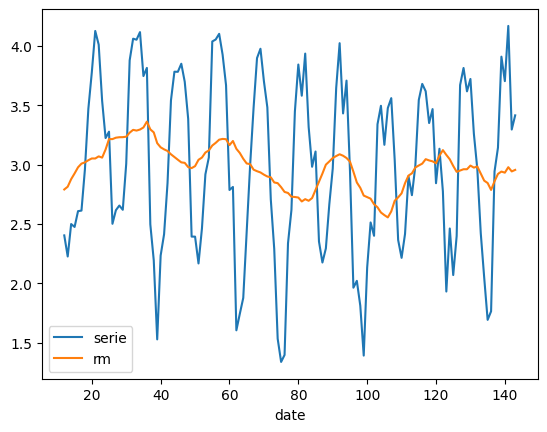

In [ ]:
ts_for = df_for['Target']
rm_size = 12
show_tend(ts_for, rm_size)

Funções de autocorrelação (ACF) e autocorrelação parcial (PACF)

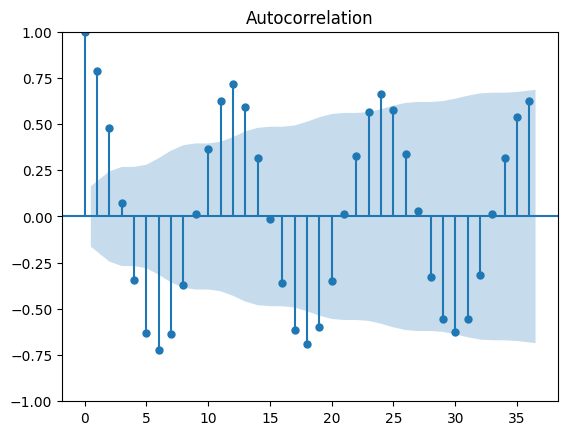

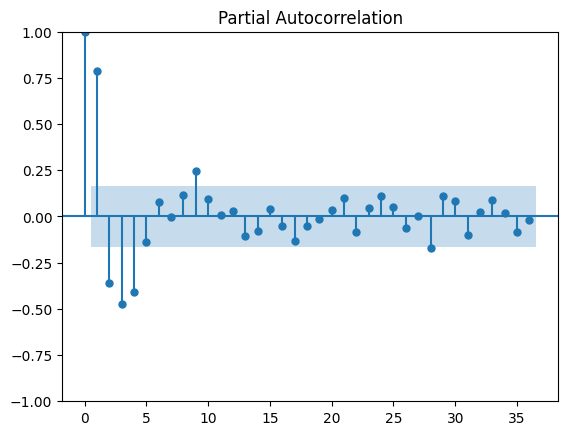

In [ ]:
plot_acf(ts_for, lags=36)
plt.show()
plot_pacf(ts_for, lags=36)
plt.show()

Teste de estacionariedade **KPSS**

In [ ]:
stat_for, p_value_for, lags_for, crit_for = kpss(ts_for, regression='c')

print("BASE FORTALEZA\n")
print(f"KPSS Statistic: {round(stat_for, 2)}")
print(f"p-value: {round(p_value_for, 2)}")
print("Nº de lags: ",round(lags_for, 2))
print("\nValores críticos:\n")
for chave, valor in crit_for.items():
    print("{} : {:0.2f}".format(chave, valor))

BASE FORTALEZA

KPSS Statistic: 0.05
p-value: 0.1
Nº de lags:  6

Valores críticos:

10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


-> `KPSS Statistic = 0.05` é menor do que todos os valores críticos.

-> `p-value = 0.1 > 0.05` -> há evidência de que a série é estacionária, não necessitando de diferenciação.

Teste **ADF**

In [ ]:
resultado_for = adfuller(ts_for)

print("BASE FORTALEZA\n")
print("ADF Statistic:", resultado_for[0])
print("p-value:", resultado_for[1])
print("Nº de lags:", resultado_for[2])
print("Nº de observações:", resultado_for[3])
print("Valores críticos:")
for chave, valor in resultado_for[4].items():
    print(f"   {chave}: {valor}")

BASE FORTALEZA

ADF Statistic: -2.6649650355657295
p-value: 0.080299519735617
Nº de lags: 9
Nº de observações: 134
Valores críticos:
   1%: -3.480118600110386
   5%: -2.8833618426136196
   10%: -2.578407034974382


-> `ADF Statistic = -2.66` é mais alto (menos negativo) do que todos o valor crítico 1 e 5%.

-> `p-value = 0.08 > 0.05` (não rejeitamos H₀, ou seja, **a serie é não estacionária**)

*p-values* **KPSS** e **ADF** discordam.

Podemos aplicar a diferenciação e reaplicar os testes.

<Axes: >

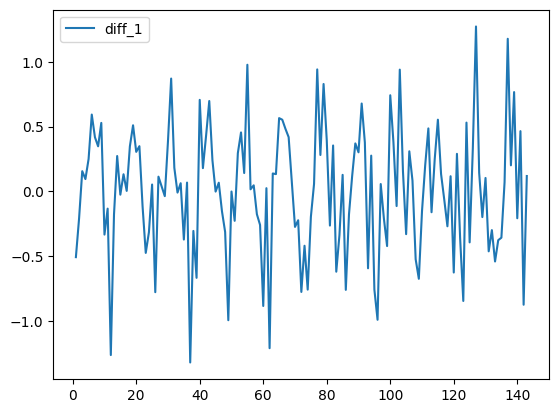

In [ ]:
df_diff_for = pd.DataFrame()
df_diff_for['diff_1'] = ts_for.diff().iloc[1:]

df_diff_for.plot()

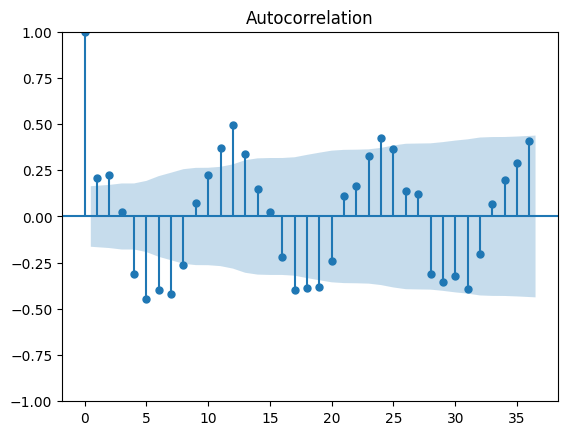

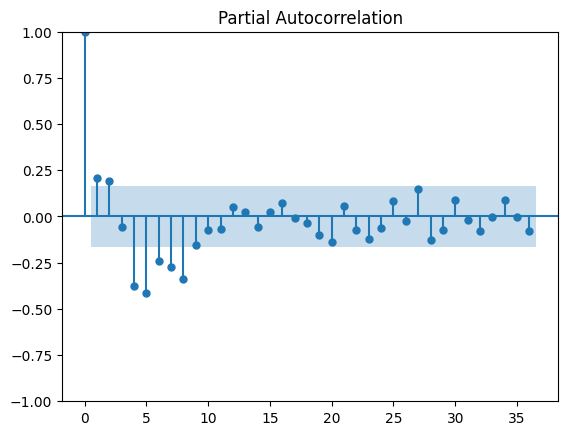

In [ ]:
ts_for = df_diff_for['diff_1']
plot_acf(ts_for, lags=36)
plt.show()
plot_pacf(ts_for, lags=36)
plt.show()

Teste de estacionariedade **KPSS** (pós diferenciação)

In [ ]:
stat_for, p_value_for, lags_for, crit_for = kpss(ts_for, regression='c')

print("BASE FORTALEZA\n")
print(f"KPSS Statistic: {round(stat_for, 2)}")
print(f"p-value: {round(p_value_for, 2)}")
print("Nº de lags: ",round(lags_for, 2))
print("\nValores críticos:\n")
for chave, valor in crit_for.items():
    print("{} : {:0.2f}".format(chave, valor))

BASE FORTALEZA

KPSS Statistic: 0.01
p-value: 0.1
Nº de lags:  5

Valores críticos:

10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


<ipython-input-34-f19d7b0685b8>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat_for, p_value_for, lags_for, crit_for = kpss(ts_for, regression='c')


Teste **ADF** (pós diferenciação)

In [ ]:
resultado_for = adfuller(ts_for)

print("BASE FORTALEZA\n")
print("ADF Statistic:", resultado_for[0])
print("p-value:", resultado_for[1])
print("Nº de lags:", resultado_for[2])
print("Nº de observações:", resultado_for[3])
print("Valores críticos:")
for chave, valor in resultado_for[4].items():
    print(f"   {chave}: {valor}")

BASE FORTALEZA

ADF Statistic: -10.15070861386846
p-value: 7.965091950003509e-18
Nº de lags: 8
Nº de observações: 134
Valores críticos:
   1%: -3.480118600110386
   5%: -2.8833618426136196
   10%: -2.578407034974382


##### Análises base Natal

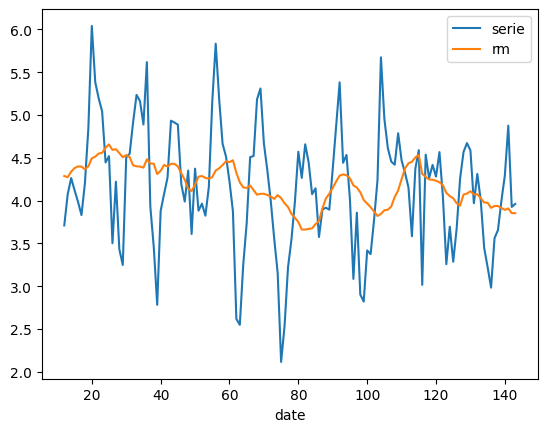

In [ ]:
ts_nat = df_nat['Target']
rm_size = 12
show_tend(ts_nat, rm_size)

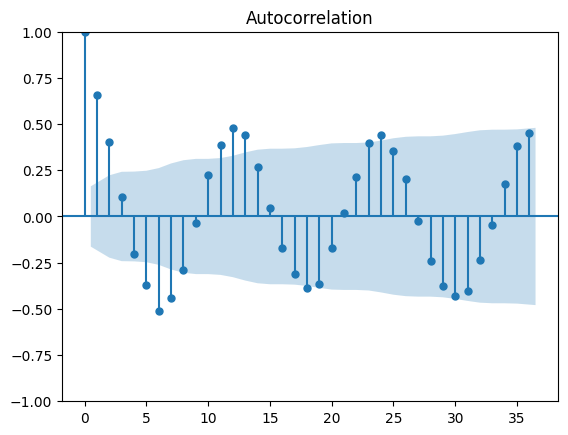

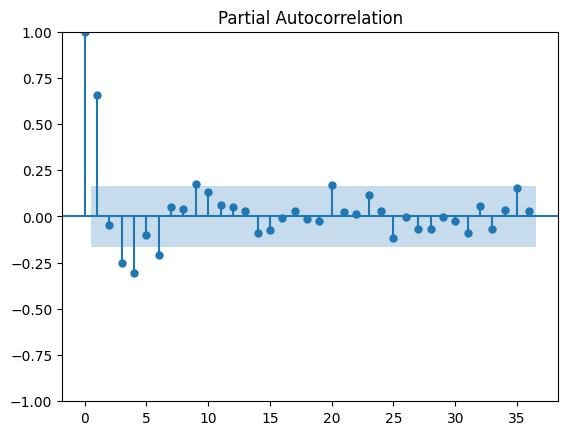

In [ ]:
plot_acf(ts_nat, lags=36)
plt.show()
plot_pacf(ts_nat, lags=36)
plt.show()

Teste de estacionariedade **KPSS**

In [ ]:
stat_nat, p_value_nat, lags_nat, crit_nat = kpss(ts_nat, regression='c')

print("BASE NATAL\n")
print(f"KPSS Statistic: {round(stat_nat, 2)}")
print(f"p-value: {round(p_value_nat, 2)}")
print("Nº de lags: ",round(lags_nat, 2))
print("\nValores críticos:\n")
for chave, valor in crit_nat.items():
    print("{} : {:0.2f}".format(chave, valor))

BASE NATAL

KPSS Statistic: 0.24
p-value: 0.1
Nº de lags:  6

Valores críticos:

10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


<ipython-input-11-d10cf5913ad4>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat_nat, p_value_nat, lags_nat, crit_nat = kpss(ts_nat, regression='c')


-> `KPSS Statistic = 0.24` é menor do que todos os valores críticos.

-> `p-value = 0.1 > 0.05` -> **Rejeitamos H₀**, ou seja, há evidência de que a série é estacionária, não necessitando de diferenciação.

Teste **ADF**

In [ ]:
resultado_nat = adfuller(ts_nat)

print("BASE NATAL\n")
print("ADF Statistic:", resultado_nat[0])
print("p-value:", resultado_nat[1])
print("Nº de lags:", resultado_nat[2])
print("Nº de observações:", resultado_nat[3])
print("Valores críticos:")
for chave, valor in resultado_nat[4].items():
    print(f"   {chave}: {valor}")

BASE NATAL

ADF Statistic: -2.7588854848580824
p-value: 0.06439091245211818
Nº de lags: 9
Nº de observações: 134
Valores críticos:
   1%: -3.480118600110386
   5%: -2.8833618426136196
   10%: -2.578407034974382


-> `ADF Statistic = -2.76` não é menor que os valores críticos de 5% ou 1%, mas é menor que o de 10%..

-> `p-value = 0.064 > 0.05` (a ADF rejeita **H₀** ao nível de 10%, mas não ao nível de 5%, indicando **indício de estacionariedade fraca**)

Podemos aplicar a diferenciação e reaplicar os testes.

<Axes: >

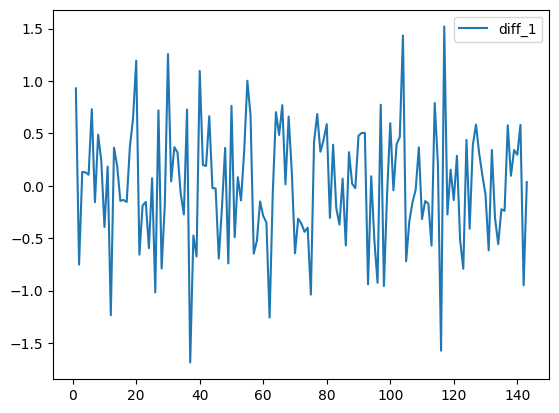

In [ ]:
df_diff_nat = pd.DataFrame()
df_diff_nat['diff_1'] = ts_nat.diff().iloc[1:]

df_diff_nat.plot()

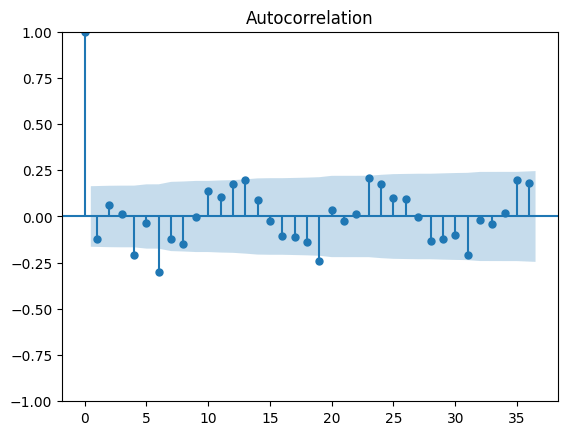

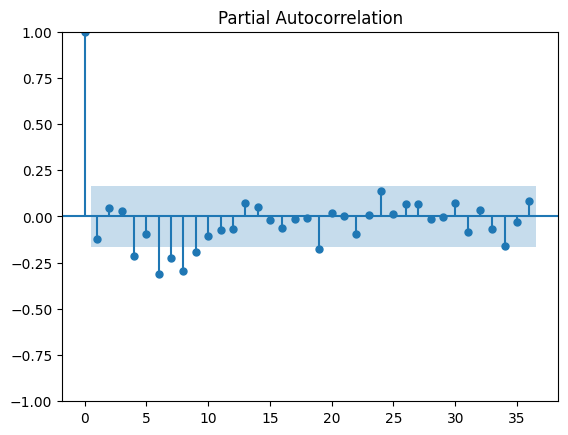

In [ ]:
ts_nat = df_diff_nat['diff_1']
plot_acf(ts_nat, lags=36)
plt.show()
plot_pacf(ts_nat, lags=36)
plt.show()

In [ ]:
stat_nat, p_value_nat, lags_nat, crit_nat = kpss(ts_nat, regression='c')

print("BASE NATAL\n")
print(f"KPSS Statistic: {round(stat_nat, 2)}")
print(f"p-value: {round(p_value_nat, 2)}")
print("Nº de lags: ",round(lags_nat, 2))
print("\nValores críticos:\n")
for chave, valor in crit_nat.items():
    print("{} : {:0.2f}".format(chave, valor))

BASE NATAL

KPSS Statistic: 0.02
p-value: 0.1
Nº de lags:  1

Valores críticos:

10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


<ipython-input-15-d10cf5913ad4>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat_nat, p_value_nat, lags_nat, crit_nat = kpss(ts_nat, regression='c')


In [ ]:
resultado_nat = adfuller(ts_nat)

print("BASE NATAL\n")
print("ADF Statistic:", resultado_nat[0])
print("p-value:", resultado_nat[1])
print("Nº de lags:", resultado_nat[2])
print("Nº de observações:", resultado_nat[3])
print("Valores críticos:")
for chave, valor in resultado_nat[4].items():
    print(f"   {chave}: {valor}")

BASE NATAL

ADF Statistic: -7.990436240581283
p-value: 2.482854926800773e-12
Nº de lags: 9
Nº de observações: 133
Valores críticos:
   1%: -3.480500383888377
   5%: -2.8835279559405045
   10%: -2.578495716547007


#### **Definição das funções: mutação, fitness, evolução, pipeline de dados, modelos**

##### Funções

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
from sklearn.metrics import mean_squared_error


def gerar_dados_temporais(ts):
    """
    Converte uma série temporal real em dados para RNN com lag fixo de 12.

    Parâmetros:
        ts: pd.Series ou np.array contendo a série temporal (ex: df['diff_1'])

    Retorna:
        X: array de shape (n_amostras, 12, 1)
        y: array de shape (n_amostras, 1)
    """
    seq_len = 12
    dados = np.array(ts).flatten()
    n_amostras = len(dados) - seq_len # 143 - 12 = 131 (i) pares X e y. i: 130 -> X[130] = dados[130:142], y[130] = dados[142]

    X, y = [], []
    for i in range(n_amostras):
        X.append(dados[i:i + seq_len])      # 12 valores de entrada - janela deslizante
        y.append(dados[i + seq_len])        # valor seguinte (13º) -> target

    # # adiciona um novo eixo a X e y
    X = np.array(X)[..., np.newaxis]        # shape: (n_amostras, 12, 11~novo eixo)
    y = np.array(y)[..., np.newaxis]        # shape: (n_amostras, 11~novo eixo)

    return X, y

# Normalizador ajustado apenas no treino
def normalizar_serie_parcial(ts_train, ts_val, ts_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    ts_train_norm = scaler.fit_transform(ts_train.reshape(-1, 1))
    ts_val_norm = scaler.transform(ts_val.reshape(-1, 1))
    ts_test_norm = scaler.transform(ts_test.reshape(-1, 1))
    return ts_train_norm, ts_val_norm, ts_test_norm, scaler

# Pipeline de dados
def pipeline_dados(ts, proporcao_treino=0.6, proporcao_val=0.2, norm=False):
    seq_len = 12
    dados = np.array(ts).reshape(-1, 1)
    n_total = len(dados) - seq_len

    n_train = int(n_total * proporcao_treino)
    n_val = int(n_total * proporcao_val)
    n_test = n_total - n_train - n_val

    idx_train = n_train + seq_len
    idx_val = idx_train + n_val

    ts_train = dados[:idx_train]
    ts_val = dados[idx_train - seq_len:idx_val]
    ts_test = dados[idx_val - seq_len:]

    if norm:
        ts_train, ts_val, ts_test, scaler = normalizar_serie_parcial(ts_train, ts_val, ts_test)
    else:
        scaler = None  # apenas pra manter compatibilidade

    X_train, y_train = gerar_dados_temporais(ts_train)
    X_val, y_val = gerar_dados_temporais(ts_val)
    X_test, y_test = gerar_dados_temporais(ts_test)

    if norm:
        return X_train, X_val, X_test, y_train, y_val, y_test, scaler
    else:
        return X_train, X_val, X_test, y_train, y_val, y_test

# Modelo base de RNN (IRÁ VARIAR DENTRO DO GRIDSEARCH)
# seq_len: janela de valores; unidades: qtd neurônios
# input_shape=(seq_len, 1): espera entradas com 'seq_len' timesteps e 1 feature por timestep
def criar_rnn(seq_len=12, unidades=12):
    #model = Sequential([
    #    SimpleRNN(unidades, input_shape=(seq_len, 1), activation='tanh'),
    #    Dense(1)

    model = Sequential([
        Input(shape=(seq_len, 1)),
        SimpleRNN(unidades, activation='tanh'),
        Dense(1)
    ])
    return model

def criar_rnn_backprop(seq_len=12, unidades=20, lr=0.001):
    """
    Cria e compila uma rede Elman (SimpleRNN) para treino com backpropagation.

    Parâmetros:
    - seq_len: número de passos de tempo na entrada
    - unidades: número de unidades da camada recorrente
    - lr: taxa de aprendizado

    Retorna:
    - modelo Keras compilado
    """
    model = Sequential([
        SimpleRNN(unidades, input_shape=(seq_len, 1), activation='tanh'),
        Dense(1)

    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Definir pesos (atribui pesos manuais ao modelo Keras)
def set_pesos(model, vetor_pesos): # model: instância do modelo Keras; vetor_pesos: vetor linear de floats (genes de um indivíduo da população)
    pesos = model.get_weights()
    shapes = [w.shape for w in pesos] # extrai os shapes de cada array de pesos (ex: [kernel, recurrent_kernel, bias, dense_kernel, dense_bias])
    novos_pesos = []
    idx = 0
    for s in shapes:
        size = np.prod(s)          # produto da dimensão de 's' (calcula qtd de valores necessários para preencher esse peso)
        novos_pesos.append(vetor_pesos[idx:idx+size].reshape(s)) # Extrai a fatia correta do 'vetor_pesos' e a redimensiona para o shape original 's'
        idx += size                # Atualiza o índice para a próxima fatia
    model.set_weights(novos_pesos) # Atribui os pesos reconstruídos ao modelo

# Fitness: erro da RNN com pesos fornecidos

# ind: vetor de pesos (indivíduo da 'pop', se torna 'vetor_pesos' na chamada de 'set_pesos()')
# X: dados de entrada da rede
# y: saídas esperadas
def fitness_rnn(ind, X, y, modelo_base):
    modelo = tf.keras.models.clone_model(modelo_base) # Cria uma cópia estrutural do modelo
    modelo.build(input_shape=(None, X.shape[1], 1))   # "Compila" a estrutura da rede para que ela possa receber pesos e aceitar entradas. X.shape[1] será igual a 'seq_len'
    set_pesos(modelo, ind)                            # Aplica os pesos da solução evoluída ao modelo copiado, garantindo que a RNN tenha comportamento definido por 'ind'
    pred = modelo.predict(X, verbose=0)               # predict do modelo com pesos evoluídos sobre os dados 'X'
    return MeanSquaredError()(y, pred).numpy()        # retorna o MSE como fitness

# Operador de mutação
def mut_gaussian(x, sigma=0.1):
    return x + np.random.normal(0, sigma, size=x.shape)

# Algoritmo de programação evolutiva (EP)
def evoluir(fitness_func, mutacao_func, X_train, y_train, X_val, y_val, modelo_base,
            n_execucoes=10, n_gen=100, tamanho_pop=30, n_genes=100):
    historico_exec_treino = []
    historico_exec_val = []

    melhor_global = None
    melhor_fitness_global = np.inf

    for execucao in range(n_execucoes):
        pop = np.random.uniform(-1, 1, size=(tamanho_pop, n_genes)) # inicialização aleatória dos pesos
        historico_treino = []
        historico_val = []

        for gen in range(n_gen):
            fitness = np.array([fitness_func(ind, X_train, y_train, modelo_base) for ind in pop])
            idx_melhor = np.argmin(fitness)
            melhor = pop[idx_melhor]                    # armazena o melhor indivíduo da 'pop' (conjunto de pesos)
            historico_treino.append(fitness[idx_melhor])

            # Avaliação no conjunto de validação
            fitness_val = fitness_func(melhor, X_val, y_val, modelo_base)
            historico_val.append(fitness_val)

            # armazena os pesos (genes) do melhor indivíduo geral para todo 'n_execucao' e 'n_gen'
            if fitness_val < melhor_fitness_global:
              melhor_global = melhor.copy()
              melhor_fitness_global = fitness_val

            # Muta o melhor para gerar a próxima população (elitista deterministica)
            pop = np.array([mutacao_func(melhor.copy()) for _ in range(tamanho_pop)])

        historico_exec_treino.append(historico_treino)
        historico_exec_val.append(historico_val)

    best_model = melhor_global # salvando o modelo da última geração
    best_fitness = melhor_fitness_global

    # Métricas de treino
    historico_exec_treino = np.array(historico_exec_treino)
    historico_medio_treino = np.mean(historico_exec_treino, axis=0)
    desvio_padrao_treino = np.std(historico_exec_treino, axis=0)
    media_final_treino = np.mean(historico_exec_treino[:, -1])

    # Métricas de validação
    historico_exec_val = np.array(historico_exec_val)
    historico_medio_val = np.mean(historico_exec_val, axis=0)
    desvio_padrao_val = np.std(historico_exec_val, axis=0)
    media_final_val = np.mean(historico_exec_val[:, -1])

    return (historico_medio_treino, desvio_padrao_treino, media_final_treino,
            historico_medio_val, desvio_padrao_val, media_final_val, best_model, best_fitness)

##### Evolução do modelo - Base Recife

###### Com normalização

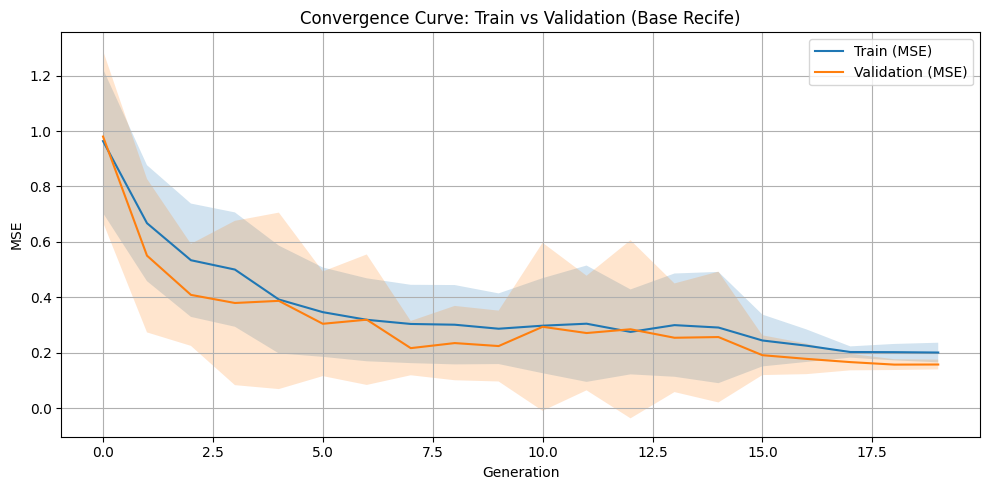


Evornn training time (base Recife) : 73 minuts and 55 seconds.


In [ ]:
'''Para normalizar a série passada para a função 'pipeline_dados', setar 'norm=True' e adicionar 'scaler' após 'y'_test
   Em caso contrário, setar 'norm=False' e remover 'scaler' após 'y_test' '''

# Pipeline completo dos dados
X_train_rec, X_val_rec, X_test_rec, y_train_rec, y_val_rec, y_test_rec, scaler_rec = pipeline_dados(ts_rec, norm=True)

# Cria o modelo base com entrada de 12 lags
modelo_base = criar_rnn(seq_len=12, unidades=20)
modelo_base.build(input_shape=(None, 12, 1))  # define o shape de entrada para uso em build()

# Dimensiona quantidade de pesos necessários a serem evoluídos para o modelo
n_genes = sum(np.prod(w.shape) for w in modelo_base.get_weights())

start_time_evornn = time.time()

resultados_rec = evoluir(
    fitness_func=fitness_rnn,
    mutacao_func=mut_gaussian,
    X_train=X_train_rec,
    y_train=y_train_rec,
    X_val=X_val_rec,
    y_val=y_val_rec,
    modelo_base=modelo_base,
    n_execucoes=10,
    n_gen=20,
    tamanho_pop=30,
    n_genes=n_genes
)

(h_treino, std_treino, final_treino,
 h_val, std_val, final_val, best_model_rec, best_fitness) = resultados_rec

# Plote das curvas de convergências
plt.figure(figsize=(10, 5))
plt.plot(h_treino, label="Train (MSE)")
plt.fill_between(range(len(h_treino)), h_treino - std_treino, h_treino + std_treino, alpha=0.2)
plt.plot(h_val, label="Validation (MSE)")
plt.fill_between(range(len(h_val)), h_val - std_val, h_val + std_val, alpha=0.2)
plt.title("Convergence Curve: Train vs Validation (Base Recife)")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

end_time_evornn = time.time()

elapsed_time_evornn = end_time_evornn - start_time_evornn
minutes_evornn = int(elapsed_time_evornn // 60)
seconds_evornn = int(elapsed_time_evornn % 60)

print(f"\nEvornn training time (base Recife) : {minutes_evornn} minuts and {seconds_evornn} seconds.")

In [ ]:
print('Base Recife:')
print(f"\nMSE final training: {final_treino :.4} +- {std_treino[-1] :.2} \nMSE final validation: {final_val :.4} +- {std_val[-1] :.3}")
print(f"\nBest MSE validation: {best_fitness :.4}")

Base Recife:

MSE final training: 0.2008 +- 0.035 
MSE final validation: 0.1575 +- 0.0176

Best MSE validation: 0.1063


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


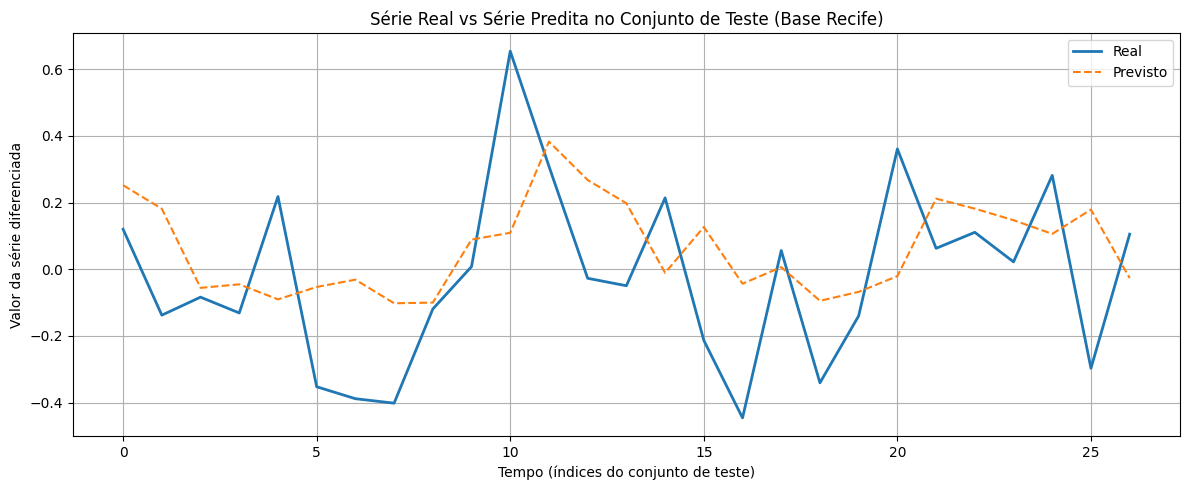

In [ ]:
# Criar modelo com mesma arquitetura
evornn_rec = tf.keras.models.clone_model(modelo_base)
evornn_rec.build(input_shape=(None, X_test_rec.shape[1], 1))

# Aplicar os melhores pesos evoluídos
set_pesos(evornn_rec, best_model_rec)

# Prever a série de teste
y_pred_evornn_rec = evornn_rec.predict(X_test_rec)

# Inverter a normalização para 'y_pred' e 'y_test'
y_pred_evornn_real_rec = scaler_rec.inverse_transform(y_pred_evornn_rec)
y_test_real_rec = scaler_rec.inverse_transform(y_test_rec)

plt.figure(figsize=(12, 5))
plt.plot(y_test_real_rec.flatten(), label="Real", linewidth=2)
plt.plot(y_pred_evornn_real_rec.flatten(), label="Previsto", linestyle='--')
plt.title("Série Real vs Série Predita no Conjunto de Teste (Base Recife)")
plt.xlabel("Tempo (índices do conjunto de teste)")
plt.ylabel("Valor da série diferenciada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
mse_test_evornn_rec  = mean_squared_error(y_test_real_rec, y_pred_evornn_real_rec)
print(f"MSE test (Elman Network + EP - Base Recife): {mse_test_evornn_rec :.4f}")

MSE test (Elman Network + EP - Base Recife): 0.0684


**Evolução para base de Recife**

###### Elman Network (otimização via gradiente)

IMPLEMENTAR PARA DEMAIS BASES, ORGANIZAR NOMEMNCLATURAS DAS SAIDAS DOS MODELOS PARA COMPARAR TODOS OS DADOS

Execução 1/10


c:\Users\Erike Simon\evornn\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10


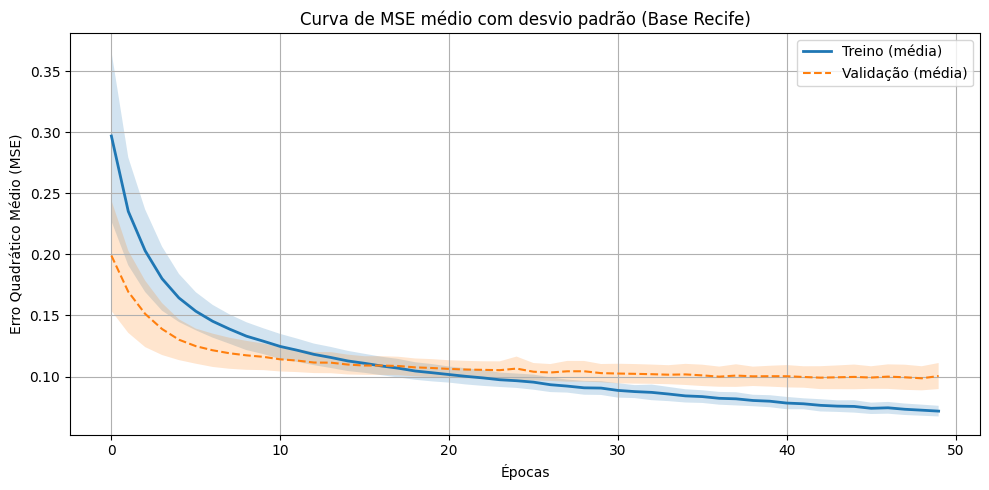

In [ ]:
n_execucoes = 10
n_epocas = 50
batch_size = 16

# Matrizes para armazenar o histórico de perda por execução
historico_treino = np.zeros((n_execucoes, n_epocas))
historico_val = np.zeros((n_execucoes, n_epocas))

#X_train_rec, X_val_rec, X_test_rec, y_train_rec, y_val_rec, y_test_rec, scaler_rec = pipeline_dados(ts_rec, norm=True)

for i in range(n_execucoes):
    print(f"Execução {i+1}/{n_execucoes}")

    modelo_rnn_rec = criar_rnn_backprop(seq_len=12, unidades=20, lr=0.001)

    history_rnn_rec = modelo_rnn_rec.fit(
        X_train_rec, y_train_rec,
        validation_data=(X_val_rec, y_val_rec),
        epochs=n_epocas,
        batch_size=batch_size,
        verbose=0
    )

    historico_treino[i, :] = history_rnn_rec.history['loss']
    historico_val[i, :] = history_rnn_rec.history['val_loss']

# Cálculo da média e do desvio padrão
mse_medio_treino = np.mean(historico_treino, axis=0)
mse_std_treino = np.std(historico_treino, axis=0)

mse_medio_val = np.mean(historico_val, axis=0)
mse_std_val = np.std(historico_val, axis=0)

# Plotagem da curva de convergência com incerteza
plt.figure(figsize=(10, 5))
plt.plot(mse_medio_treino, label="Treino (média)", linewidth=2)
plt.fill_between(range(n_epocas), mse_medio_treino - mse_std_treino, mse_medio_treino + mse_std_treino, alpha=0.2)

plt.plot(mse_medio_val, label="Validação (média)", linestyle='--')
plt.fill_between(range(n_epocas), mse_medio_val - mse_std_val, mse_medio_val + mse_std_val, alpha=0.2)

plt.title("Curva de MSE médio com desvio padrão (Base Recife)")
plt.xlabel("Épocas")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print('Elman + BPTT - Base Recife:')
print(f"\nMSE final training : {round(mse_medio_treino[-1], 4)} +- {round(mse_std_treino[-1], 4)} \nMSE final validation: {round(mse_medio_val[-1], 4)} +- {round(mse_std_val[-1], 4)}")

Elman + BPTT - Base Recife:

MSE final training : 0.0717 +- 0.0044 
MSE final validation: 0.1004 +- 0.0107


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


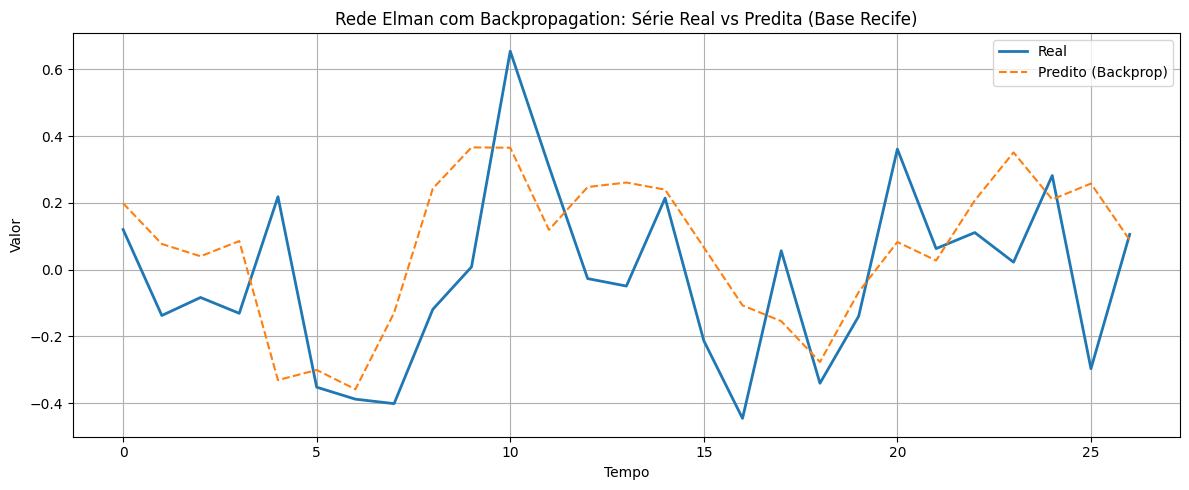

In [ ]:
# Previsão no teste
y_pred_bptt_rec = modelo_rnn_rec.predict(X_test_rec)

# Inversão da normalização
y_pred_bptt_real_rec = scaler_rec.inverse_transform(y_pred_bptt_rec)
y_test_real_rec = scaler_rec.inverse_transform(y_test_rec)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_real_rec.flatten(), label="Real", linewidth=2)
plt.plot(y_pred_bptt_real_rec.flatten(), label="Predito (Backprop)", linestyle='--')
plt.title("Rede Elman com Backpropagation: Série Real vs Predita (Base Recife)")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse_teste_bptt_rec = mean_squared_error(y_test_real_rec, y_pred_bptt_real_rec)

print('Elman Network + BPTT - Base Recife')
print(f"\nMSE test: {mse_teste_bptt_rec:.4f}")

Elman Network + BPTT - Base Recife

MSE test: 0.0667


###### ARIMA

OBS: Não ha necessidade de normalizar o ARIMA, pois trabalham diretamente com valores absolutos da série (e não com distâncias ou gradientes como RNAs), além de serem invariantes da escala linear. Ou seja, não há ganho em aplicar normalização.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Série Recife diferenciada
ts = np.array(ts_rec).flatten()

# Mesmo tamanho d eteste dos modelos EvoRNN e Elman + backpropagation
size_test = 27

ts_train_arima_rec = ts[:-size_test]
ts_test_arima_rec = ts[-size_test:]

melhor_score = np.inf
melhor_order = None

# Grid Search para p, d e q
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                modelo = ARIMA(ts_train_arima_rec, order=(p, d, q))
                modelo_fit = modelo.fit()
                y_pred = modelo_fit.forecast(steps=len(ts_test_arima_rec))
                mse = mean_squared_error(ts_test_arima_rec, y_pred)
                if mse < melhor_score:
                    melhor_score = mse
                    melhor_order = (p, d, q)
            except:
                continue

print(f"Melhor ordem ARIMA (Base Recife): {melhor_order} com MSE = {melhor_score:.4f}")

Melhor ordem ARIMA (Base Recife): (2, 0, 2) com MSE = 0.0495


In [ ]:
# Previsão one-step-ahead (com atualização)
historico = list(ts_train_arima_rec)
y_pred_arima_rec = []

for t in ts_test_arima_rec:
    modelo = ARIMA(historico, order=melhor_order)
    modelo_fit = modelo.fit()
    yhat = modelo_fit.forecast(steps=1)[0]
    y_pred_arima_rec.append(yhat)
    historico.append(t)

# MSE da previsão one-step-ahead
mse_arima_rec = mean_squared_error(ts_test_arima_rec, y_pred_arima_rec)
print("One-step-ahead ARIMA - Base Recife")
print(f"\nMSE teste: {mse_arima_rec:.4f}")

One-step-ahead ARIMA - Base Recife

MSE teste: 0.0478


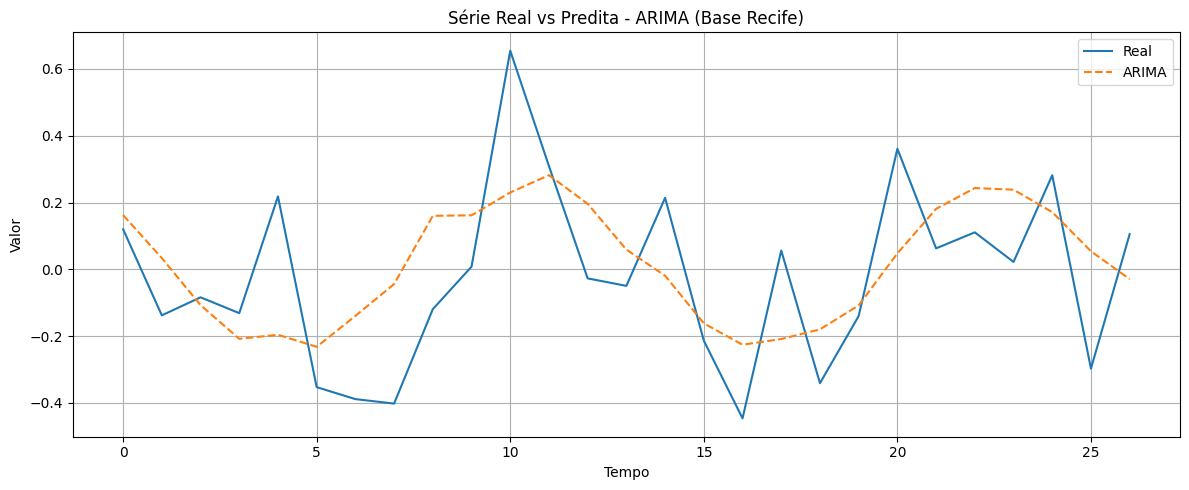

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(ts_test_arima_rec, label='Real') # poderia usar aqui também o 'y_test_real_rec'
plt.plot(y_pred_arima_rec, label='ARIMA', linestyle='--')
plt.title('Série Real vs Predita - ARIMA (Base Recife)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###### Plot geral

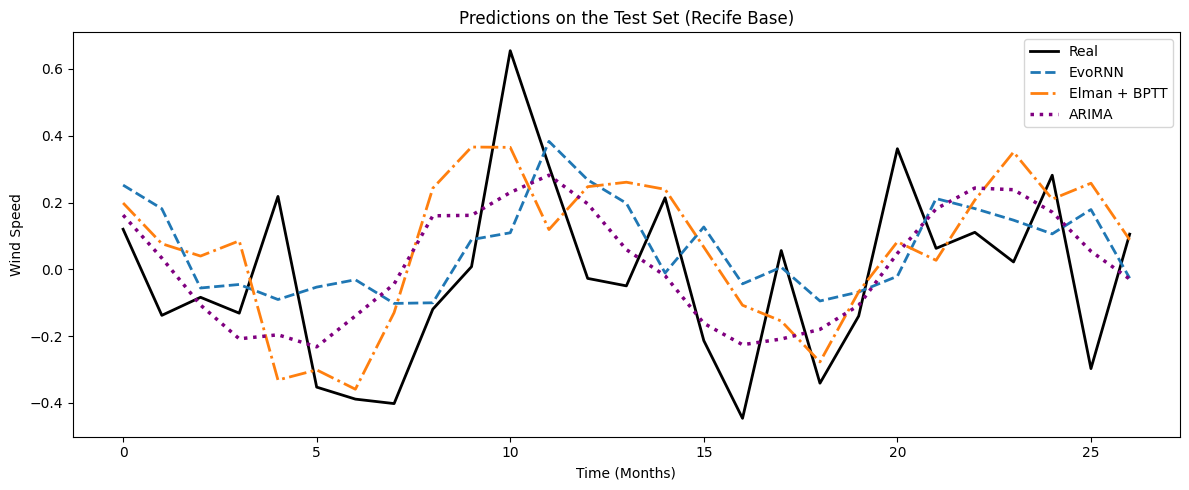

In [ ]:
plt.figure(figsize=(12, 5))

# Série real
plt.plot(y_test_real_rec.flatten(), label="Real", linewidth=2, color='black')

# Previsões
plt.plot(y_pred_evornn_real_rec.flatten(), label="EvoRNN", linestyle='--', linewidth=2)
plt.plot(y_pred_bptt_real_rec.flatten(), label="Elman + BPTT", linestyle='-.', linewidth=2)
plt.plot(y_pred_arima_rec, label="ARIMA", linestyle=':', linewidth=2.5, color='purple')

plt.title("Predictions on the Test Set (Recife Base)")
plt.xlabel("Time (Months)")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
print("Base Recife")
print(f"\nMSE test (EvoRNN): {mse_test_evornn_rec :.4f}")
print(f"MSE test (Elman + BPTT): {mse_teste_bptt_rec:.4f}")
print(f"MSE test (ARIMA): {mse_arima_rec:.4f}")

Base Recife

MSE test (EvoRNN): 0.0684
MSE test (Elman + BPTT): 0.0667
MSE test (ARIMA): 0.0478


##### Evolução do modelo - Base Fortaleza

###### Com normalização

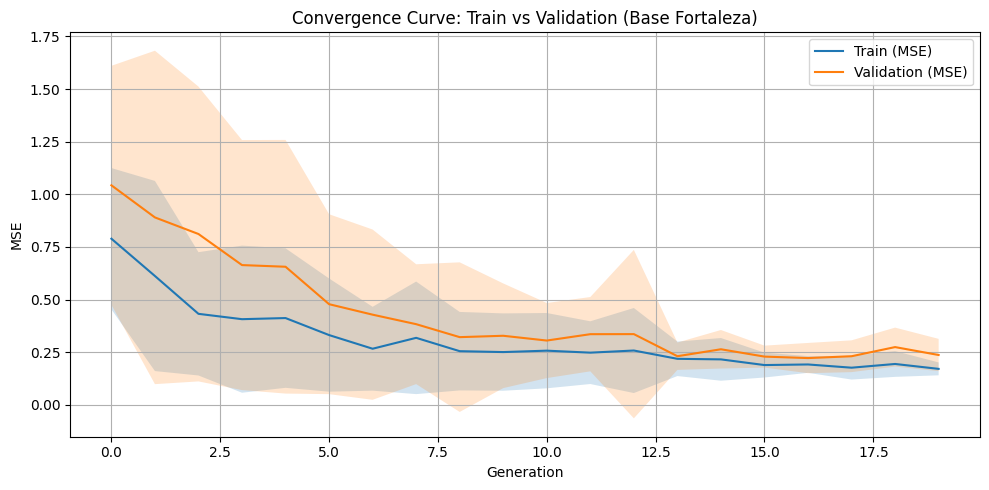


Evornn training time : 50 minuts and 48 seconds.


In [ ]:
'''Para normalizar a série passada para a função 'pipeline_dados', setar 'norm=True' e adicionar 'scaler' após 'y'_test
   Em caso contrário, setar 'norm=False' e remover 'scaler' após 'y_test' '''

X_train_for, X_val_for, X_test_for, y_train_for, y_val_for, y_test_for, scaler_for = pipeline_dados(ts_for, norm=True)

# Cria o modelo base com entrada de 12 lags
modelo_base = criar_rnn(seq_len=12, unidades=20)
modelo_base.build(input_shape=(None, 12, 1))  # define o shape de entrada para uso em build()

# Dimensiona quantidade de pesos a serem evoluídos necessárias para o modelo
n_genes = sum(np.prod(w.shape) for w in modelo_base.get_weights())

start_time_evornn = time.time()

results_evornn_for_norm = evoluir(
    fitness_func=fitness_rnn,
    mutacao_func=mut_gaussian,
    X_train=X_train_for,
    y_train=y_train_for,
    X_val=X_val_for,
    y_val=y_val_for,
    modelo_base=modelo_base,
    n_execucoes=10,
    n_gen=20,
    tamanho_pop=30,
    n_genes=n_genes
)

# COM POP 30, 30 UNIDADES NEURONIOS E 20 GERACOES SUPEROU RNN BACK

(h_treino, std_treino, final_treino,
 h_val, std_val, final_val, best_model_for, best_fitness) = results_evornn_for_norm

# Plote das curvas de convergências
plt.figure(figsize=(10, 5))
plt.plot(h_treino, label="Train (MSE)")
plt.fill_between(range(len(h_treino)), h_treino - std_treino, h_treino + std_treino, alpha=0.2)
plt.plot(h_val, label="Validation (MSE)")
plt.fill_between(range(len(h_val)), h_val - std_val, h_val + std_val, alpha=0.2)
plt.title("Convergence Curve: Train vs Validation (Base Fortaleza)")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

end_time_evornn = time.time()

elapsed_time_evornn = end_time_evornn - start_time_evornn
minutes_evornn = int(elapsed_time_evornn // 60)
seconds_evornn = int(elapsed_time_evornn % 60)

print(f"\nEvornn training time : {minutes_evornn} minuts and {seconds_evornn} seconds.")

In [ ]:
print('Base Fortaleza:')
print(f"\nMSE final training: {final_treino :.4} +- {std_treino[-1] :.2} \nMSE final validation: {final_val :.4} +- {std_val[-1] :.3}")
print(f"\nBest MSE validation: {best_fitness :.4}")

Base Fortaleza:

MSE final training: 0.1706 +- 0.031 
MSE final validation: 0.2365 +- 0.0767

Best MSE validation: 0.0798


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


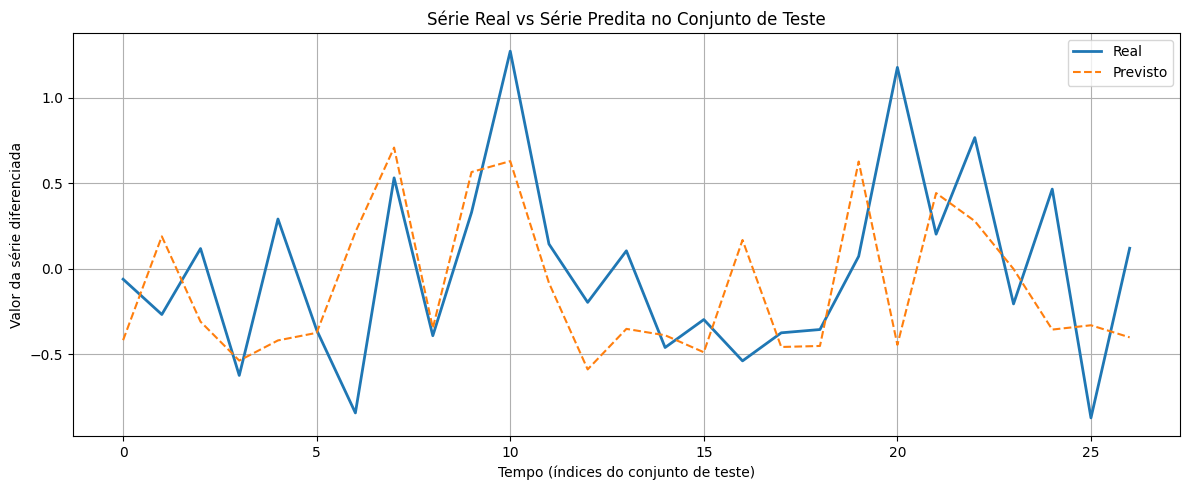

In [ ]:
evornn_for = tf.keras.models.clone_model(modelo_base)
evornn_for.build(input_shape=(None, X_test_for.shape[1], 1))

set_pesos(evornn_for, best_model_for)

# Prever a série de teste
y_pred_evornn_for = evornn_for.predict(X_test_for)

# Inverter a normalização para 'y_pred' e 'y_test'
y_pred_evornn_real_for = scaler_for.inverse_transform(y_pred_evornn_for)
y_test_real_for = scaler_for.inverse_transform(y_test_for)

plt.figure(figsize=(12, 5))
plt.plot(y_test_real_for.flatten(), label="Real", linewidth=2)
plt.plot(y_pred_evornn_real_for.flatten(), label="Previsto", linestyle='--')
plt.title("Série Real vs Série Predita no Conjunto de Teste")
plt.xlabel("Tempo (índices do conjunto de teste)")
plt.ylabel("Valor da série diferenciada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse_test_evornn_for  = mean_squared_error(y_test_real_for, y_pred_evornn_real_for)
print(f"MSE test (EvoRNN - Base Fortaleza): {mse_test_evornn_for :.5f}")

MSE test (EvoRNN - Base Fortaleza): 0.30186


###### Elman Network (otimização via gradiente)

Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10


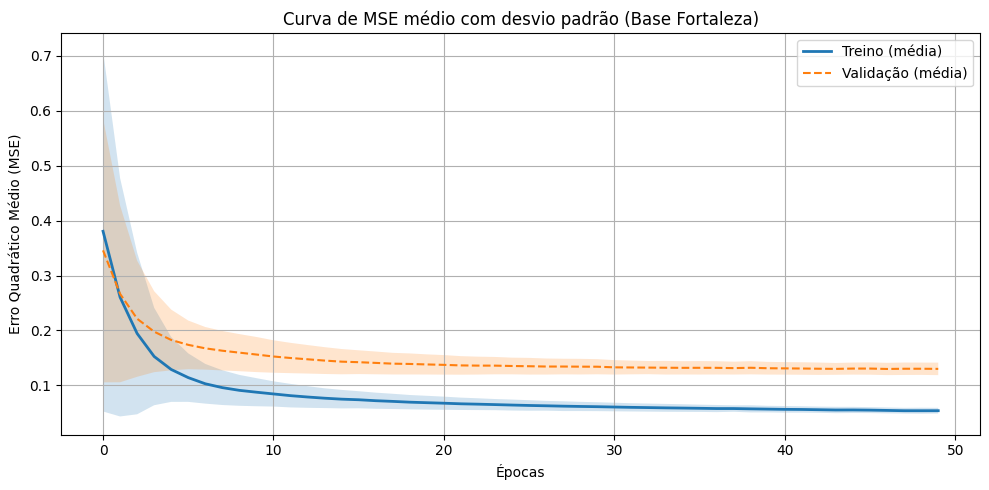

In [ ]:
n_execucoes = 10
n_epocas = 50
batch_size = 16

# Matrizes para armazenar o histórico de perda por execução
historico_treino = np.zeros((n_execucoes, n_epocas))
historico_val = np.zeros((n_execucoes, n_epocas))

#X_train, X_val, X_test, y_train, y_val, y_test, scaler = pipeline_dados(ts_for, norm=True)

for i in range(n_execucoes):
    print(f"Execução {i+1}/{n_execucoes}")

    modelo = criar_rnn_backprop(seq_len=12, unidades=20, lr=0.001)

    history = modelo.fit(
        X_train_for, y_train_for,
        validation_data=(X_val_for, y_val_for),
        epochs=n_epocas,
        batch_size=batch_size,
        verbose=0
    )

    historico_treino[i, :] = history.history['loss']
    historico_val[i, :] = history.history['val_loss']

# Cálculo da média e do desvio padrão
mse_medio_treino = np.mean(historico_treino, axis=0)
mse_std_treino = np.std(historico_treino, axis=0)

mse_medio_val = np.mean(historico_val, axis=0)
mse_std_val = np.std(historico_val, axis=0)

# Plotagem da curva de convergência com incerteza
plt.figure(figsize=(10, 5))
plt.plot(mse_medio_treino, label="Treino (média)", linewidth=2)
plt.fill_between(range(n_epocas), mse_medio_treino - mse_std_treino, mse_medio_treino + mse_std_treino, alpha=0.2)

plt.plot(mse_medio_val, label="Validação (média)", linestyle='--')
plt.fill_between(range(n_epocas), mse_medio_val - mse_std_val, mse_medio_val + mse_std_val, alpha=0.2)

plt.title("Curva de MSE médio com desvio padrão (Base Fortaleza)")
plt.xlabel("Épocas")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print('Elman + BPTT - Base Fortaleza:')
print(f"\nMSE final training : {round(mse_medio_treino[-1], 4)} +- {round(mse_std_treino[-1], 4)} \nMSE final validation: {round(mse_medio_val[-1], 4)} +- {round(mse_std_val[-1], 4)}")

Elman + BPTT - Base Fortaleza:

MSE final training : 0.0538 +- 0.0052 
MSE final validation: 0.13 +- 0.0114


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


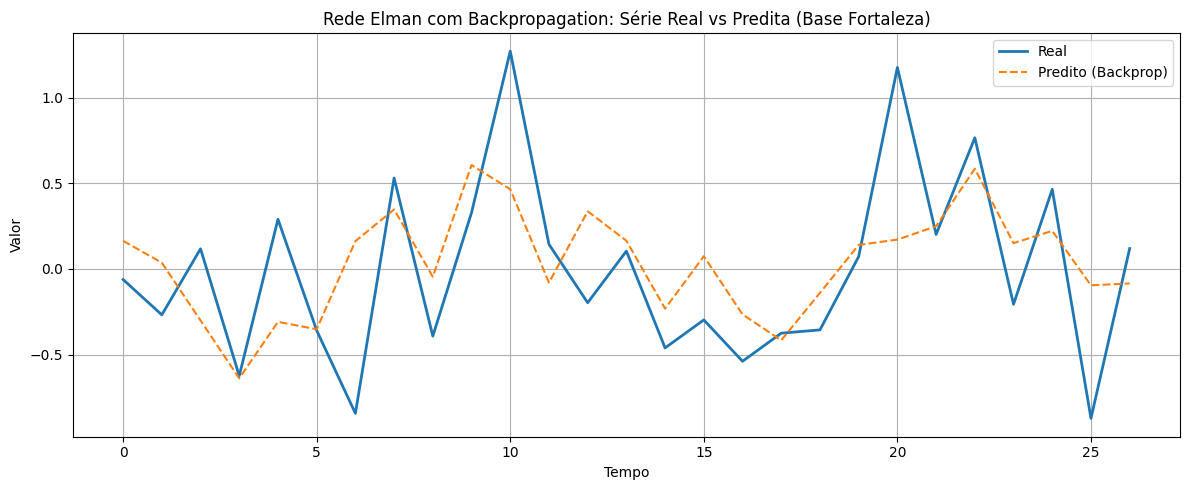

In [ ]:
# Previsão no teste
y_pred_bptt_for = modelo.predict(X_test_for)

# Inversão da normalização
y_pred_bptt_real_for = scaler_for.inverse_transform(y_pred_bptt_for)
y_test_real_for = scaler_for.inverse_transform(y_test_for)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_real_for.flatten(), label="Real", linewidth=2)
plt.plot(y_pred_bptt_real_for.flatten(), label="Predito (Backprop)", linestyle='--')
plt.title("Rede Elman com Backpropagation: Série Real vs Predita (Base Fortaleza)")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse_test_bptt_for = mean_squared_error(y_test_real_for, y_pred_bptt_real_for)
print(f"MSE test (Elman Network + EP - Base Fortaleza): {mse_test_bptt_for:.5f}")

MSE test (Elman Network + EP - Base Fortaleza): 0.18938


###### ARIMA

In [ ]:
# Série Fortaleza diferenciada
ts = np.array(ts_for).flatten()

# Mesmo tamanho d eteste dos modelos EvoRNN e Elman + backpropagation
size_test = 27

ts_train_arima_for = ts[:-size_test]
ts_test_arima_for = ts[-size_test:]

melhor_score = np.inf
melhor_order = None

# Grid Search para p, d e q
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                modelo = ARIMA(ts_train_arima_for, order=(p, d, q))
                modelo_fit = modelo.fit()
                y_pred = modelo_fit.forecast(steps=len(ts_test_arima_for))
                mse = mean_squared_error(ts_test_arima_for, y_pred)
                if mse < melhor_score:
                    melhor_score = mse
                    melhor_order = (p, d, q)
            except:
                continue

print(f"Melhor ordem ARIMA (Base Fortaleza): {melhor_order} com MSE = {melhor_score:.4f}")

Melhor ordem ARIMA (Base Fortaleza): (2, 0, 2) com MSE = 0.1934


In [ ]:
# Previsão one-step-ahead (com atualização)
historico = list(ts_train_arima_for)
y_pred_arima_for = []

for t in ts_test_arima_for:
    modelo = ARIMA(historico, order=melhor_order)
    modelo_fit = modelo.fit()
    yhat = modelo_fit.forecast(steps=1)[0]
    y_pred_arima_for.append(yhat)
    historico.append(t)

# MSE da previsão one-step-ahead
mse_arima_for = mean_squared_error(ts_test_arima_for, y_pred_arima_for)
print(f"MSE one-step-ahead ARIMA - Base Fortaleza: {mse_arima_for:.4f}")

MSE one-step-ahead ARIMA - Base Fortaleza: 0.1979


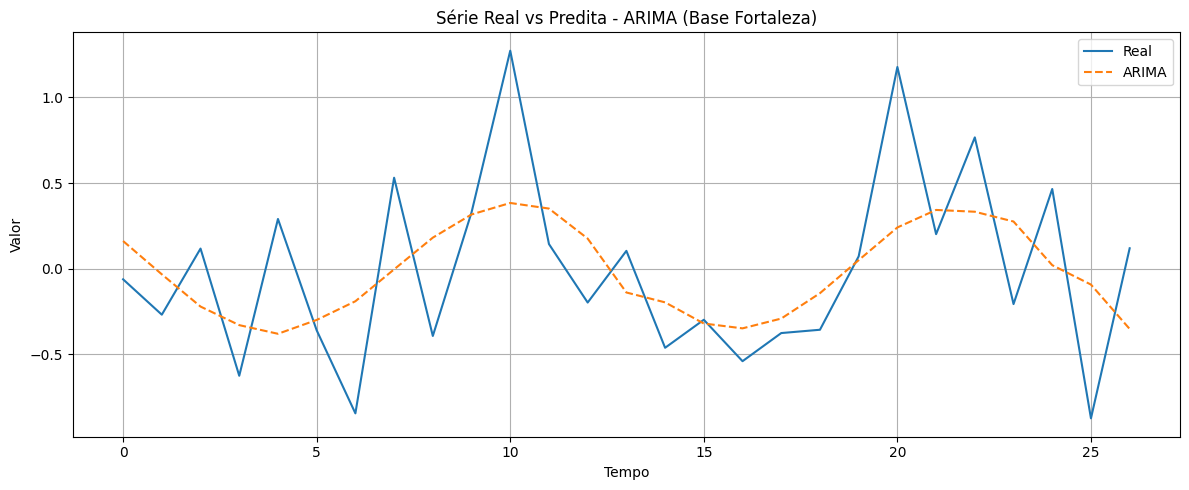

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(ts_test_arima_for, label='Real')
plt.plot(y_pred_arima_for, label='ARIMA', linestyle='--')
plt.title('Série Real vs Predita - ARIMA (Base Fortaleza)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###### Plot Geral

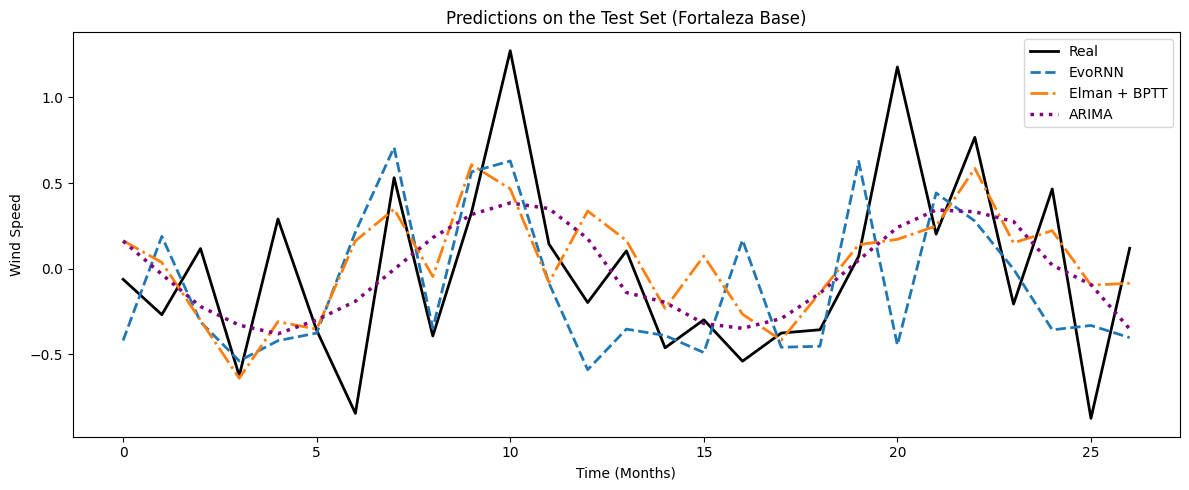

In [ ]:
plt.figure(figsize=(12, 5))

# Série real
plt.plot(y_test_real_for.flatten(), label="Real", linewidth=2, color='black')

# Previsões
plt.plot(y_pred_evornn_real_for.flatten(), label="EvoRNN", linestyle='--', linewidth=2)
plt.plot(y_pred_bptt_real_for.flatten(), label="Elman + BPTT", linestyle='-.', linewidth=2)
plt.plot(y_pred_arima_for, label="ARIMA", linestyle=':', linewidth=2.5, color='purple')

plt.title("Predictions on the Test Set (Fortaleza Base)")
plt.xlabel("Time (Months)")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
print("Base Fortaleza")
print(f"\nMSE test (EvoRNN): {mse_test_evornn_for :.4f}")
print(f"MSE test (Elman + BPTT): {mse_test_bptt_for:.4f}")
print(f"MSE test (ARIMA): {mse_arima_for:.4f}")

Base Fortaleza

MSE test (EvoRNN): 0.3019
MSE test (Elman + BPTT): 0.1894
MSE test (ARIMA): 0.1979


##### Evolução do modelo - Base Natal

###### Com normalização

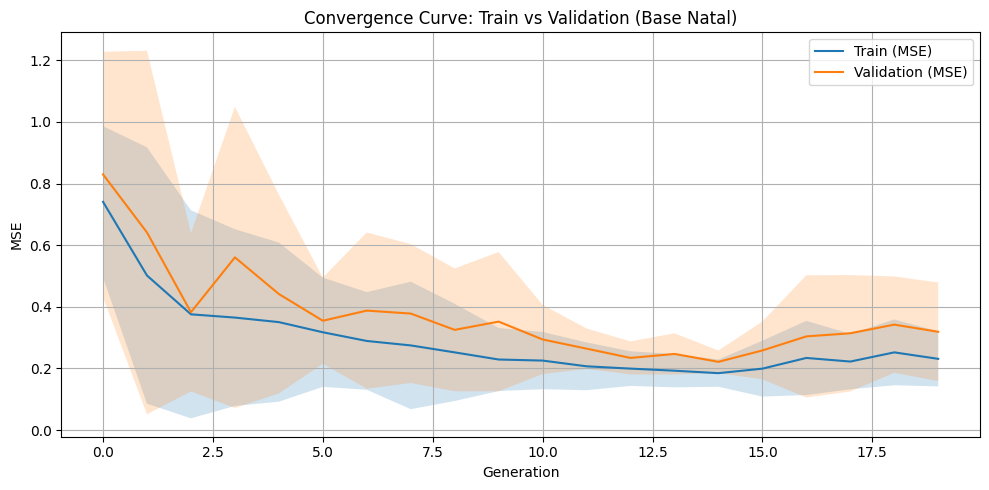


Evornn training time : 68 minuts and 55 seconds.


In [ ]:
'''Para normalizar a série passada para a função 'pipeline_dados', setar 'norm=True' e adicionar 'scaler' após 'y'_test
   Em caso contrário, setar 'norm=False' e remover 'scaler' após 'y_test' '''

X_train_nat, X_val_nat, X_test_nat, y_train_nat, y_val_nat, y_test_nat, scaler_nat = pipeline_dados(ts_nat, norm=True)

# Cria o modelo base com entrada de 12 lags
modelo_base = criar_rnn(seq_len=12, unidades=20)
modelo_base.build(input_shape=(None, 12, 1))  # define o shape de entrada para uso em build()

# Dimensiona quantidade de pesos a serem evoluídos necessárias para o modelo
n_genes = sum(np.prod(w.shape) for w in modelo_base.get_weights())

start_time_evornn = time.time()

resultados_nat = evoluir(
    fitness_func=fitness_rnn,
    mutacao_func=mut_gaussian,
    X_train=X_train_nat,
    y_train=y_train_nat,
    X_val=X_val_nat,
    y_val=y_val_nat,
    modelo_base=modelo_base,
    n_execucoes=10,
    n_gen=20,
    tamanho_pop=30,
    n_genes=n_genes
)

(h_treino, std_treino, final_treino,
 h_val, std_val, final_val, best_model, best_fitness) = resultados_nat

# Plote das curvas de convergências
plt.figure(figsize=(10, 5))
plt.plot(h_treino, label="Train (MSE)")
plt.fill_between(range(len(h_treino)), h_treino - std_treino, h_treino + std_treino, alpha=0.2)
plt.plot(h_val, label="Validation (MSE)")
plt.fill_between(range(len(h_val)), h_val - std_val, h_val + std_val, alpha=0.2)
plt.title("Convergence Curve: Train vs Validation (Base Natal)")
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

end_time_evornn = time.time()

elapsed_time_evornn = end_time_evornn - start_time_evornn
minutes_evornn = int(elapsed_time_evornn // 60)
seconds_evornn = int(elapsed_time_evornn % 60)

print(f"\nEvornn training time : {minutes_evornn} minuts and {seconds_evornn} seconds.")

In [ ]:
print('Base Natal:')
print(f"\nMSE final training: {final_treino :.4} +- {std_treino[-1] :.2} \nMSE final validation: {final_val :.4} +- {std_val[-1] :.3}")
print(f"\nBest MSE validation: {best_fitness :.4}")

Base Natal:

MSE final training: 0.231 +- 0.089 
MSE final validation: 0.3188 +- 0.16

Best MSE validation: 0.1618


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


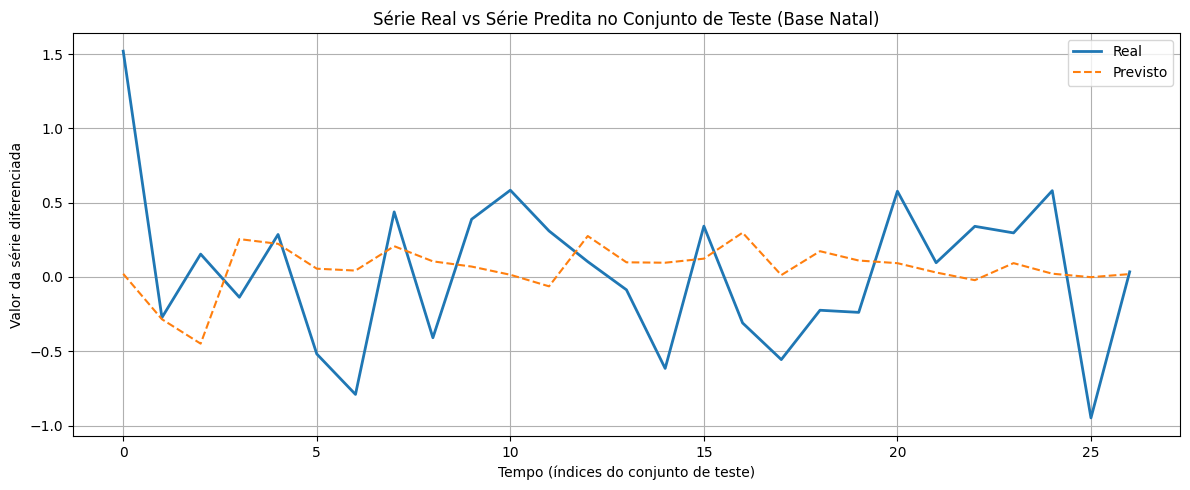

In [ ]:
# Criar modelo com mesma arquitetura
evornn_nat = tf.keras.models.clone_model(modelo_base)
evornn_nat.build(input_shape=(None, X_test_nat.shape[1], 1))

# Aplicar os melhores pesos evoluídos
set_pesos(evornn_nat, best_model)

# Prever a série de teste
y_pred_evornn_nat = evornn_nat.predict(X_test_nat)

# Inverter a normalização para 'y_pred' e 'y_test'
y_pred_evornn_real_nat = scaler_nat.inverse_transform(y_pred_evornn_nat)
y_test_real_nat = scaler_nat.inverse_transform(y_test_nat)

plt.figure(figsize=(12, 5))
plt.plot(y_test_real_nat.flatten(), label="Real", linewidth=2)
plt.plot(y_pred_evornn_real_nat.flatten(), label="Previsto", linestyle='--')
plt.title("Série Real vs Série Predita no Conjunto de Teste (Base Natal)")
plt.xlabel("Tempo (índices do conjunto de teste)")
plt.ylabel("Valor da série diferenciada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse_test_evornn_nat = mean_squared_error(y_test_real_nat, y_pred_evornn_real_nat)
print(f"MSE test (EvoRNN- Base Natal): {mse_test_evornn_nat:.5f}")

MSE test (EvoRNN- Base Natal): 0.29204


###### Elman Network (otimização via gradiente)

Execução 1/10


Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10


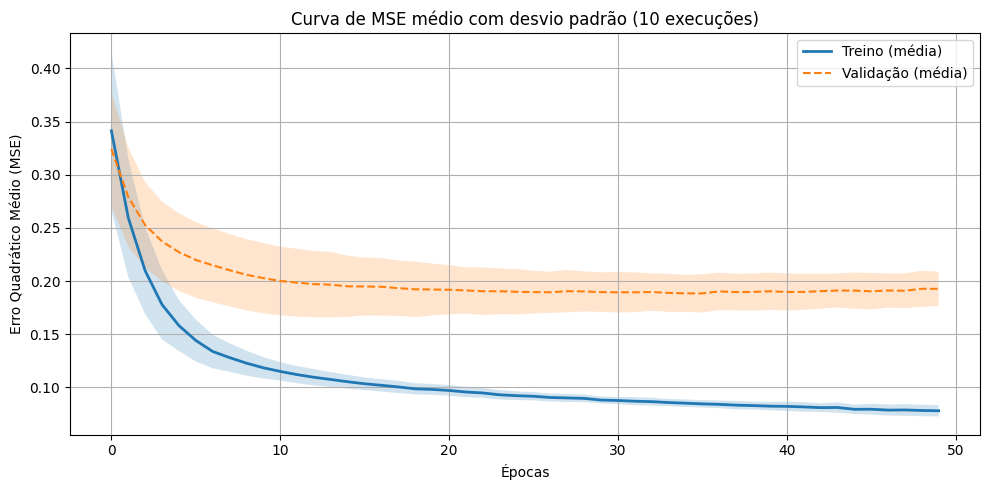

In [ ]:
n_execucoes = 10
n_epocas = 50
batch_size = 16

# Matrizes para armazenar o histórico de perda por execução
historico_treino = np.zeros((n_execucoes, n_epocas))
historico_val = np.zeros((n_execucoes, n_epocas))

#X_train, X_val, X_test, y_train, y_val, y_test, scaler = pipeline_dados(ts_nat, norm=True)

for i in range(n_execucoes):
    print(f"Execução {i+1}/{n_execucoes}")

    modelo = criar_rnn_backprop(seq_len=12, unidades=20, lr=0.001)

    history = modelo.fit(
        X_train_nat, y_train_nat,
        validation_data=(X_val_nat, y_val_nat),
        epochs=n_epocas,
        batch_size=batch_size,
        verbose=0
    )

    historico_treino[i, :] = history.history['loss']
    historico_val[i, :] = history.history['val_loss']

# Cálculo da média e do desvio padrão
mse_medio_treino = np.mean(historico_treino, axis=0)
mse_std_treino = np.std(historico_treino, axis=0)

mse_medio_val = np.mean(historico_val, axis=0)
mse_std_val = np.std(historico_val, axis=0)

# Plotagem da curva de convergência com incerteza
plt.figure(figsize=(10, 5))
plt.plot(mse_medio_treino, label="Treino (média)", linewidth=2)
plt.fill_between(range(n_epocas), mse_medio_treino - mse_std_treino, mse_medio_treino + mse_std_treino, alpha=0.2)

plt.plot(mse_medio_val, label="Validação (média)", linestyle='--')
plt.fill_between(range(n_epocas), mse_medio_val - mse_std_val, mse_medio_val + mse_std_val, alpha=0.2)

plt.title("Curva de MSE médio com desvio padrão (10 execuções)")
plt.xlabel("Épocas")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print('Elman + BPTT - Base Natal:')
print(f"\nMSE final training : {round(mse_medio_treino[-1], 4)} +- {round(mse_std_treino[-1], 4)} \nMSE final validation: {round(mse_medio_val[-1], 4)} +- {round(mse_std_val[-1], 4)}")

Elman + BPTT - Base Natal:

MSE final training : 0.0779 +- 0.0053 
MSE final validation: 0.1926 +- 0.016


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


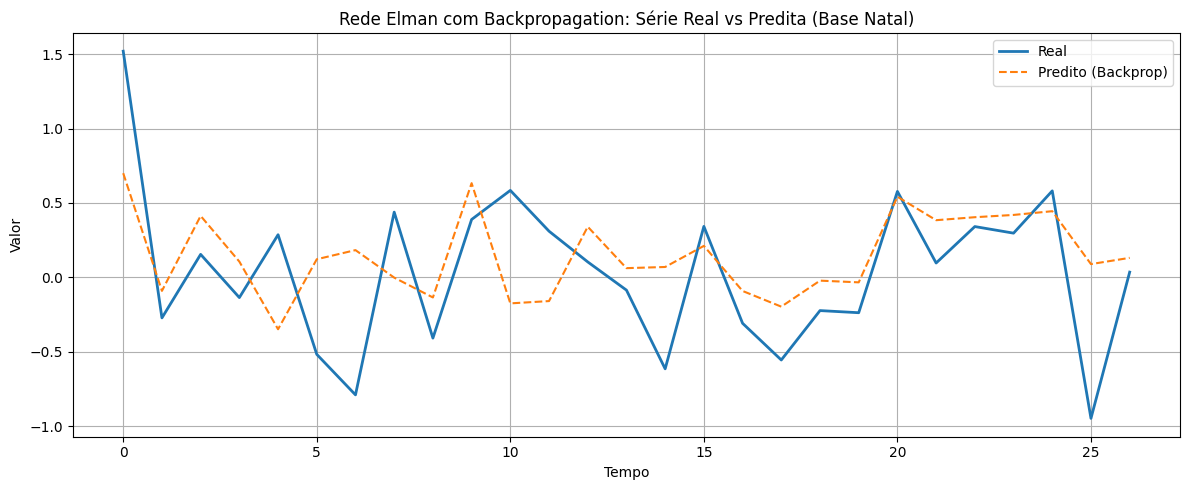

In [ ]:
# Previsão no teste
y_pred_bptt_nat = modelo.predict(X_test_nat)

# Inversão da normalização
y_pred_bptt_real_nat = scaler_nat.inverse_transform(y_pred_bptt_nat)
y_test_real_nat = scaler_nat.inverse_transform(y_test_nat)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_real_nat.flatten(), label="Real", linewidth=2)
plt.plot(y_pred_bptt_real_nat.flatten(), label="Predito (Backprop)", linestyle='--')
plt.title("Rede Elman com Backpropagation: Série Real vs Predita (Base Natal)")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse_test_bptt_nat = mean_squared_error(y_test_real_nat, y_pred_bptt_real_nat)
print(f"MSE test (Elman Network + EP - Base Fortaleza): {mse_test_bptt_nat:.5f}")

MSE test (Elman Network + EP - Base Fortaleza): 0.21279


###### ARIMA

In [ ]:
# Série Fortaleza diferenciada
ts = np.array(ts_nat).flatten()

# Mesmo tamanho d eteste dos modelos EvoRNN e Elman + backpropagation
size_test = 27

ts_train_arima_nat = ts[:-size_test]
ts_test_arima_nat = ts[-size_test:]

melhor_score = np.inf
melhor_order = None

# Grid Search para p, d e q
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                modelo = ARIMA(ts_train_arima_nat, order=(p, d, q))
                modelo_fit = modelo.fit()
                y_pred = modelo_fit.forecast(steps=len(ts_test_arima_nat))
                mse = mean_squared_error(ts_test_arima_nat, y_pred)
                if mse < melhor_score:
                    melhor_score = mse
                    melhor_order = (p, d, q)
            except:
                continue

print(f"Melhor ordem ARIMA (Base Natal): {melhor_order} com MSE = {melhor_score:.4f}")

Melhor ordem ARIMA (Base Natal): (2, 0, 3) com MSE = 0.2096


In [ ]:
# Previsão one-step-ahead (com atualização)
historico = list(ts_train_arima_nat)
y_pred_arima_nat = []

for t in ts_test_arima_nat:
    modelo = ARIMA(historico, order=melhor_order)
    modelo_fit = modelo.fit()
    yhat = modelo_fit.forecast(steps=1)[0]
    y_pred_arima_nat.append(yhat)
    historico.append(t)

# MSE da previsão one-step-ahead
mse_arima_nat = mean_squared_error(ts_test_arima_nat, y_pred_arima_nat)
print(f"MSE one-step-ahead ARIMA - Base Natal: {mse_arima_nat:.4f}")

MSE one-step-ahead ARIMA - Base Natal: 0.2576


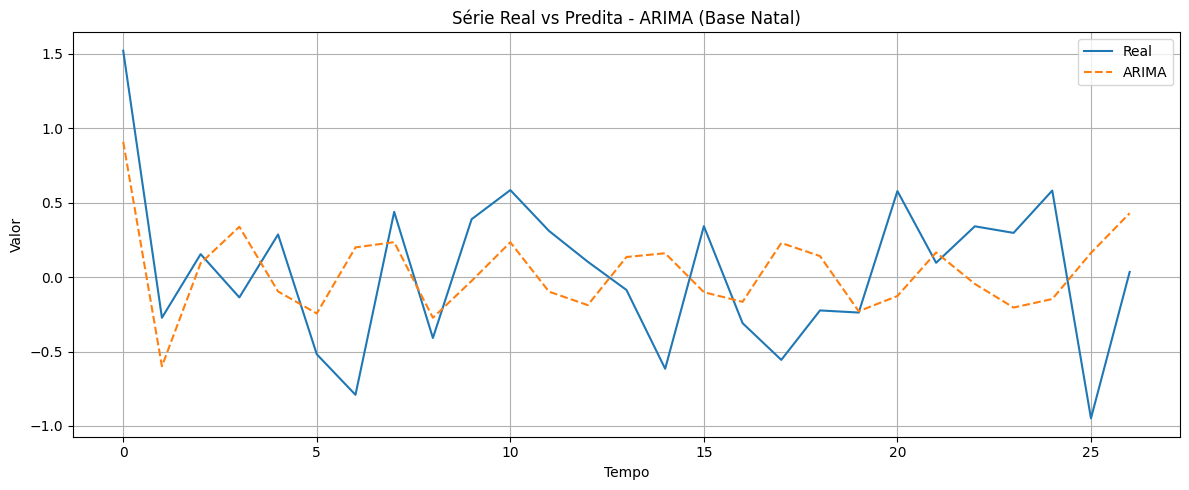

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(ts_test_arima_nat, label='Real')
plt.plot(y_pred_arima_nat, label='ARIMA', linestyle='--')
plt.title('Série Real vs Predita - ARIMA (Base Natal)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###### Plot Geral

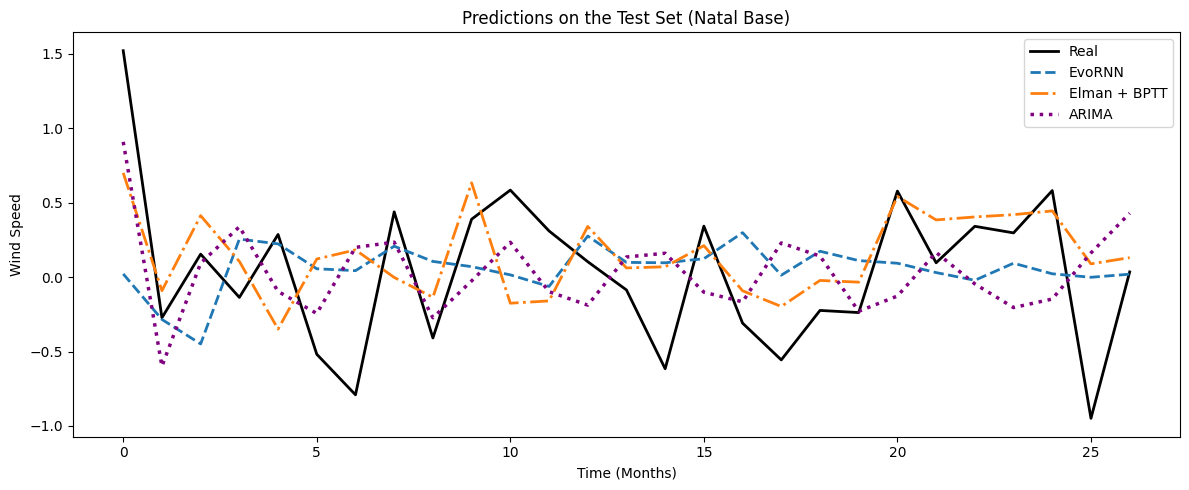

In [ ]:
plt.figure(figsize=(12, 5))

# Série real
plt.plot(y_test_real_nat.flatten(), label="Real", linewidth=2, color='black')

# Previsões
plt.plot(y_pred_evornn_real_nat.flatten(), label="EvoRNN", linestyle='--', linewidth=2)
plt.plot(y_pred_bptt_real_nat.flatten(), label="Elman + BPTT", linestyle='-.', linewidth=2)
plt.plot(y_pred_arima_nat, label="ARIMA", linestyle=':', linewidth=2.5, color='purple')

plt.title("Predictions on the Test Set (Natal Base)")
plt.xlabel("Time (Months)")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
print("Base Natal")
print(f"\nMSE test (EvoRNN): {mse_test_evornn_nat :.4f}")
print(f"MSE test (Elman + BPTT): {mse_test_bptt_nat:.4f}")
print(f"MSE test (ARIMA): {mse_arima_nat:.4f}")

Base Natal

MSE test (EvoRNN): 0.2920
MSE test (Elman + BPTT): 0.2128
MSE test (ARIMA): 0.2576
